# NetCDF4 compression using xarray

The `encode_dataset` function in this Python notebook introduces two types of compression, lossy and lossless, for NetCDF4 files using xarray. It demonstrates the effectiveness of zlib compression, offering control over precision for lossy compression. Performance is particularly enhanced for smooth datasets, showcasing improved results compared to random datasets due to inherent data correlation.

In [1]:
from os.path import getsize, join
from tempfile import TemporaryDirectory
from time import perf_counter
from typing import Any, Dict, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
def size_mo(path):
    return getsize(path)/2**20


def monitor_save_nc(ds):
    with TemporaryDirectory() as temp_dir:
        temp_path = join(temp_dir, 'temp.nc')
        st = perf_counter()
        ds.to_netcdf(temp_path, format='NETCDF4')
        t = perf_counter() - st
        return size_mo(temp_path), t

In [3]:
def encode_dataset(ds: xr.Dataset, complevel: int = 6, least_significant_digit: Optional[Union[int, Dict[str, int]]] = None, to_float32: bool = True, chunksizes: Optional[Tuple[int, ...]] = None, reset_encoding: bool = False) -> xr.Dataset:
    """
    Encodes a dataset with optional compression and encoding parameters.

    Args:
        ds (xr.Dataset): The dataset to encode.
        complevel (int, optional): Compression level. Defaults to 6.
        least_significant_digit (Union[int, Dict[str, int]], optional): Least significant digit(s) to preserve during encoding. Can be specified globally or for specific variables. Defaults to None.
        to_float32 (bool, optional): Convert integer types to float32 if True. Defaults to True.
        chunksizes (Tuple[int, ...], optional): Chunk sizes for encoding. Defaults to None.
        reset_encoding (bool, optional): Reset encoding parameters if True, otherwise update existing encoding. Defaults to False.

    Returns:
        xr.Dataset: The encoded dataset.
    """

    encoding = {"zlib": True, "complevel": complevel}

    for k in ds.variables:
        if ds[k].dtype.kind in 'bfi':
            if to_float32:
                ds[k].astype(np.float32)
            if reset_encoding:
                ds[k].encoding = encoding
            else:
                ds[k].encoding.update(encoding)
        elif reset_encoding:
            ds[k].encoding = {}

    if isinstance(chunksizes, tuple):
        for k in ds:
            ds[k].encoding.update({'chunksizes': chunksizes})

    if isinstance(least_significant_digit, int):
        for k in ds:
            ds[k].encoding.update({"least_significant_digit": least_significant_digit})
    if isinstance(least_significant_digit, dict):
        for k in ds:
            if k in least_significant_digit:
                ds[k].encoding.update({"least_significant_digit": least_significant_digit[k]})
    return ds

In [4]:
def random_dataset(nt, ny, nx, nvars=3):
    alphabet = list(map(chr, range(97, 123)))
    ds = {k: (('time', 'y', 'x'), np.random.randn(nt, ny, nx)) for k in alphabet[:nvars]}
    ds = xr.Dataset(ds)
    return ds


random_ds = random_dataset(24, 150, 200)
random_ds

<xarray.Dataset> Size: 17MB
Dimensions:  (time: 24, y: 150, x: 200)
Dimensions without coordinates: time, y, x
Data variables:
    a        (time, y, x) float64 6MB 0.6855 0.2216 0.8823 ... 1.127 1.074
    b        (time, y, x) float64 6MB 0.02837 1.258 -1.961 ... 0.5168 0.5098
    c        (time, y, x) float64 6MB -0.1164 0.2687 1.101 ... 0.9335 0.2492

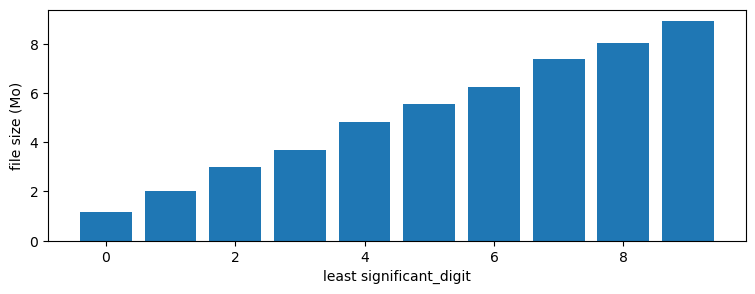

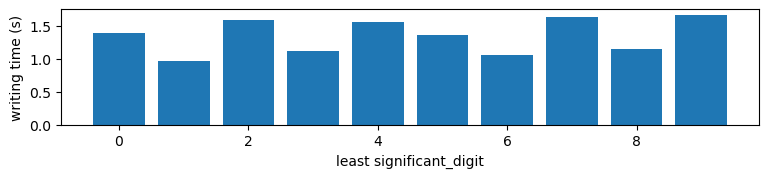

In [5]:
ls = list(range(10))
files_sizes, time_save = [], []

for ls_value in ls:
    encode_dataset(random_ds, least_significant_digit=ls_value)
    s, t = monitor_save_nc(random_ds)
    files_sizes.append(s)
    time_save.append(t)

plt.figure(figsize=(9, 3))
plt.bar(x=ls, height=files_sizes)
plt.xlabel('least significant_digit')
plt.ylabel('file size (Mo)')
plt.show()

plt.figure(figsize=(9, 1.5))
plt.bar(x=ls, height=time_save)
plt.xlabel('least significant_digit')
plt.ylabel('writing time (s)')
plt.show()

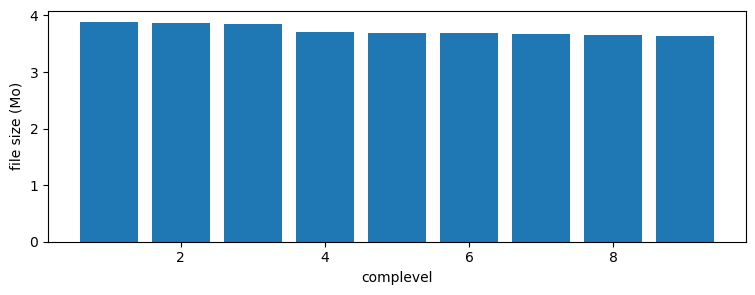

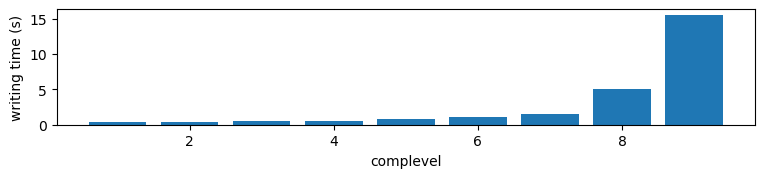

In [6]:
c = list(range(1, 10))
files_sizes, time_save = [], []

for c_value in c:
    encode_dataset(random_ds, least_significant_digit=3, complevel=c_value)
    s, t = monitor_save_nc(random_ds)
    files_sizes.append(s)
    time_save.append(t)

plt.figure(figsize=(9, 3))
plt.bar(x=c, height=files_sizes)
plt.xlabel('complevel')
plt.ylabel('file size (Mo)')
plt.show()

plt.figure(figsize=(9, 1.5))
plt.bar(x=c, height=time_save)
plt.xlabel('complevel')
plt.ylabel('writing time (s)')
plt.show()

In [7]:
def smooth_dataset(nt, ny, nx, nvars=3):
    alphabet = list(map(chr, range(97, 123)))

    def f(nt, ny, nx):
        x = np.linspace(-1, 1, nx)
        y = np.linspace(-1, 1, ny)
        ret = 3*(x[None, :, None]**2 + y[None, None, :]**2) + np.linspace(0, 2*np.pi, nt)[:, None, None]
        ret = np.cos(ret)
        return ret

    ds = {k: (('time', 'y', 'x'), f(nt, ny, nx)) for k in alphabet[:nvars]}
    ds = xr.Dataset(ds)
    return ds


smooth_ds = smooth_dataset(24, 150, 200)
smooth_ds

<xarray.Dataset> Size: 17MB
Dimensions:  (time: 24, y: 200, x: 150)
Dimensions without coordinates: time, y, x
Data variables:
    a        (time, y, x) float64 6MB 0.9602 0.9348 0.9039 ... 0.9348 0.9602
    b        (time, y, x) float64 6MB 0.9602 0.9348 0.9039 ... 0.9348 0.9602
    c        (time, y, x) float64 6MB 0.9602 0.9348 0.9039 ... 0.9348 0.9602

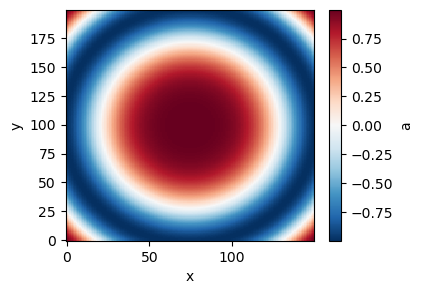

In [8]:
smooth_ds['a'].isel(time=0).plot(figsize=(4, 3))

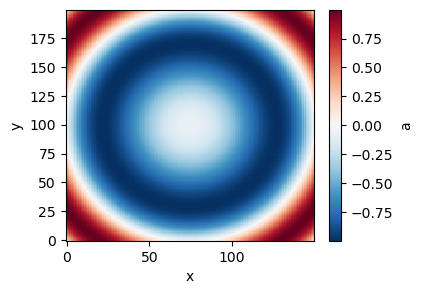

In [9]:
smooth_ds['a'].isel(time=6).plot(figsize=(4, 3))

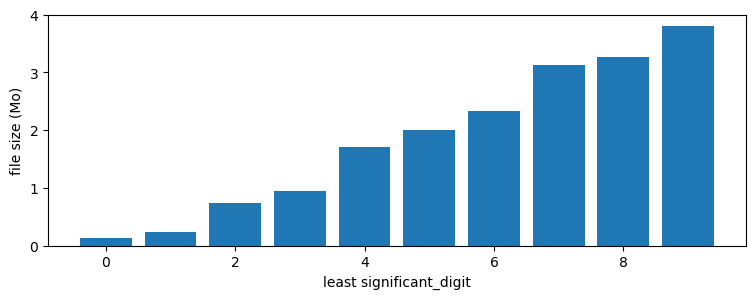

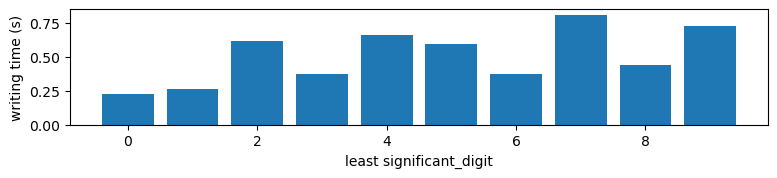

In [10]:
ls = list(range(10))
files_sizes, time_save = [], []

for ls_value in ls:
    encode_dataset(smooth_ds, least_significant_digit=ls_value)
    s, t = monitor_save_nc(smooth_ds)
    files_sizes.append(s)
    time_save.append(t)

plt.figure(figsize=(9, 3))
plt.bar(x=ls, height=files_sizes)
plt.xlabel('least significant_digit')
plt.ylabel('file size (Mo)')
plt.show()

plt.figure(figsize=(9, 1.5))
plt.bar(x=ls, height=time_save)
plt.xlabel('least significant_digit')
plt.ylabel('writing time (s)')
plt.show()